**Khai báo thư viện**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from keras.applications import ResNet50
from tensorflow.keras.layers import Flatten,Dense,Dropout
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os

##**Tiền xử lý dữ liệu**

In [4]:
from imutils import paths
imgTrain = list(paths.list_images("/content/drive/MyDrive/chest_xray/train"))
imgTest = list(paths.list_images("/content/drive/MyDrive/chest_xray/test"))

In [5]:
X_train = []
y_train = []

In [6]:
for path_train in imgTrain:

	Y_train = path_train.split(os.path.sep)[-2]

	# Xu ly anh
	img = cv2.imread(path_train)
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	img = cv2.resize(img, (150, 150))

	# Them vao du lieu data va label
	X_train.append(img)
	y_train.append(Y_train)

In [7]:
from sklearn.preprocessing import LabelBinarizer

X_train = np.array(X_train)
y_train = np.array(y_train)
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
X_train = X_train.astype('float32') / 255

**TEST**

In [8]:
X_test = []
y_test = []

In [9]:
for path_test in imgTest:

	Y_test = path_test.split(os.path.sep)[-2]

	# Xu ly anh
	img1 = cv2.imread(path_test)
	img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
	img1 = cv2.resize(img1, (150, 150))

	# Them vao du lieu data va label
	X_test.append(img1)
	y_test.append(Y_test)

In [10]:
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = lb.fit_transform(y_test)
X_test = X_test.astype('float32') / 255

##**XÂY DỰNG MÔ HÌNH**

In [11]:
import tensorflow as tf

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), # Lớp tích chập 2D, 32 bộ lọc kích thước 3 x 3, hàm kích hoạt là ReLU
                                                                                          # kích thước ảnh đầu vào 150x150 với 3 kênh màu
    tf.keras.layers.MaxPooling2D(2,2), # Lớp MaxPooling 2D kích thước 2x2 dùng để giảm kích thước và số lượng đặc trưng thông qua lấy giá trị lớn nhất trong mỗi vùng pool.
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), # Lớp tích chập với 32 filter kích thước 3x3 và 32 bộ lọc
    tf.keras.layers.MaxPooling2D(2,2), # Lớp MaxPooling 2D
    tf.keras.layers.Flatten(), # chuyển đổi đầu ra từ tensor nhiều chiều thành một vector 1D.
    tf.keras.layers.Dense(128, activation = tf.nn.relu), # Lớp kết nối đầy đủ với 128 đơn vị và hàm kích hoạt là ReLU
    tf.keras.layers.Dense(2, activation = tf.nn.softmax) # phân loại đối tượng vào 2 lớp khác nhau, hàm softmax để tạo phân phối xác suất trên các lớp
])

In [13]:
model.compile(optimizer = 'adam', # phương pháp tối ưu hóa Adam
                     loss = 'sparse_categorical_crossentropy', # hàm mất mát đo sự khác biệt giữa đầu ra dự đoán và nhãn thực tế;
                     # sparse categorical cross-entropy thích hợp khi nhãn đầu vào không được mã hóa theo one-hot encoding, mà là các giá trị số nguyên
                     metrics = ['accuracy']) # các độ đo để đánh giá hiệu suất của mô hình. Độ chính xác ('accuracy') là tỷ lệ giữa số dự đoán đúng và tổng số mẫu

In [14]:
# Kiến trúc mô hình
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [15]:
# Huấn luyện mô hình
epochs3 = 15
history3 = model.fit(
  X_train, y_train,
  validation_data = (X_test, y_test),
  epochs = epochs3,
  batch_size = 32)

Epoch 1/15
164/164 [==============================] - 154s 929ms/step - loss: 0.2369 - accuracy: 0.9098 - val_loss: 0.9980 - val_accuracy: 0.7324
Epoch 2/15
164/164 [==============================] - 160s 971ms/step - loss: 0.0935 - accuracy: 0.9687 - val_loss: 0.8704 - val_accuracy: 0.7821
Epoch 3/15
164/164 [==============================] - 153s 932ms/step - loss: 0.0730 - accuracy: 0.9715 - val_loss: 1.1753 - val_accuracy: 0.7260
Epoch 4/15
164/164 [==============================] - 158s 962ms/step - loss: 0.0560 - accuracy: 0.9805 - val_loss: 1.1338 - val_accuracy: 0.7612
Epoch 5/15
164/164 [==============================] - 166s 1s/step - loss: 0.0338 - accuracy: 0.9887 - val_loss: 1.2284 - val_accuracy: 0.7644
Epoch 6/15
164/164 [==============================] - 152s 926ms/step - loss: 0.0469 - accuracy: 0.9826 - val_loss: 1.4868 - val_accuracy: 0.7500
Epoch 7/15
164/164 [==============================] - 151s 920ms/step - loss: 0.0296 - accuracy: 0.9893 - val_loss: 1.6586 - va

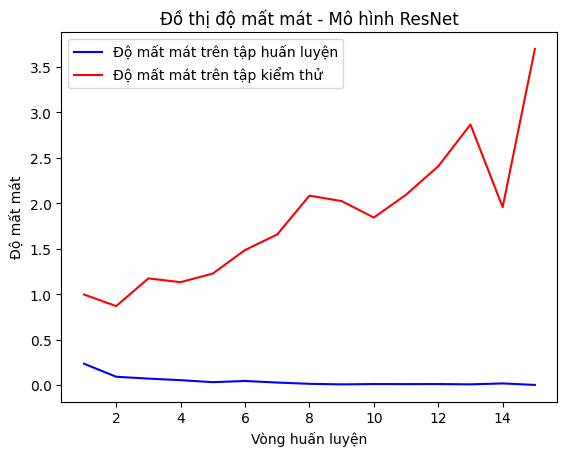

In [16]:
# Đồ thị hàm mất mát
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs = range(1, len(loss3)+1)
plt.plot(epochs, loss3, 'b', label = 'Độ mất mát trên tập huấn luyện')
plt.plot(epochs, val_loss3, 'r', label = 'Độ mất mát trên tập kiểm thử')
plt.title('Đồ thị độ mất mát - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ mất mát')
plt.legend()
plt.show()

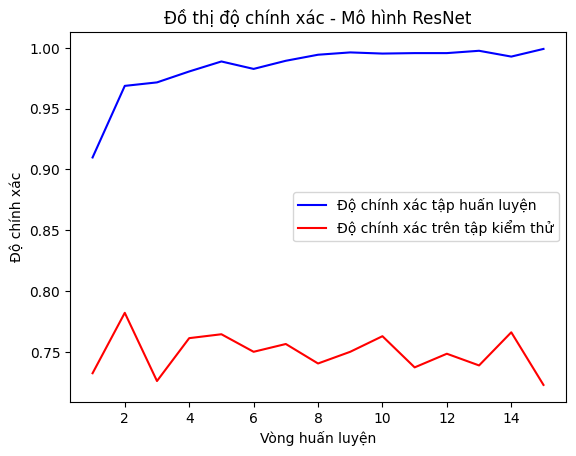

In [17]:
# Đồ thị độ chính xác của mô hình
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
plt.plot(epochs, acc3, 'b', label = 'Độ chính xác tập huấn luyện')
plt.plot(epochs, val_acc3, 'r', label = 'Độ chính xác trên tập kiểm thử')
plt.title('Đồ thị độ chính xác - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ chính xác')
plt.legend()
plt.show()

**ẢNH XÁM**

In [18]:
X_train_gray = []
y_train_gray = []

In [19]:
for path_train in imgTrain:

	Y_train_gray = path_train.split(os.path.sep)[-2]

	# Xu ly anh
	img_gray = cv2.imread(path_train)
	img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
	img_gray = cv2.resize(img_gray, (150, 150))

	# Them vao du lieu data va label
	X_train_gray.append(img_gray)
	y_train_gray.append(Y_train_gray)

In [20]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

X_train_gray = np.array(X_train_gray)
y_train_gray = np.array(y_train_gray)

y_train_gray = lb.fit_transform(y_train_gray)
X_train_gray = X_train_gray.astype('float32') / 255

In [21]:
X_test_gray = []
y_test_gray = []

In [22]:
for path_test in imgTest:

	Y_test_gray = path_test.split(os.path.sep)[-2]

	# Xu ly anh
	img1_gray = cv2.imread(path_test)
	img1_gray = cv2.cvtColor(img1_gray, cv2.COLOR_BGR2GRAY)
	img1_gray = cv2.resize(img1_gray, (150, 150))

	# Them vao du lieu data va label
	X_test_gray.append(img1_gray)
	y_test_gray.append(Y_test_gray)

In [23]:
X_test_gray = np.array(X_test_gray)
y_test_gray = np.array(y_test_gray)
y_test_gray = lb.fit_transform(y_test_gray)
X_test_gray = X_test_gray.astype('float32') / 255

In [24]:
import tensorflow as tf

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 1)), # Lớp tích chập 2D, 32 bộ lọc kích thước 3 x 3, hàm kích hoạt là ReLU
                                                                                          # kích thước ảnh đầu vào 150x150 với 3 kênh màu
    tf.keras.layers.MaxPooling2D(2,2), # Lớp MaxPooling 2D kích thước 2x2 dùng để giảm kích thước và số lượng đặc trưng thông qua lấy giá trị lớn nhất trong mỗi vùng pool.
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), # Lớp tích chập với 32 filter kích thước 3x3 và 32 bộ lọc
    tf.keras.layers.MaxPooling2D(2,2), # Lớp MaxPooling 2D
    tf.keras.layers.Flatten(), # chuyển đổi đầu ra từ tensor nhiều chiều thành một vector 1D.
    tf.keras.layers.Dense(128, activation = tf.nn.relu), # Lớp kết nối đầy đủ với 128 đơn vị và hàm kích hoạt là ReLU
    tf.keras.layers.Dense(2, activation = tf.nn.softmax) # phân loại đối tượng vào 2 lớp khác nhau, hàm softmax để tạo phân phối xác suất trên các lớp
])

In [26]:
model.compile(optimizer = 'adam', # phương pháp tối ưu hóa Adam
                     loss = 'sparse_categorical_crossentropy', # hàm mất mát đo sự khác biệt giữa đầu ra dự đoán và nhãn thực tế;
                     # sparse categorical cross-entropy thích hợp khi nhãn đầu vào không được mã hóa theo one-hot encoding, mà là các giá trị số nguyên
                     metrics = ['accuracy']) # các độ đo để đánh giá hiệu suất của mô hình. Độ chính xác ('accuracy') là tỷ lệ giữa số dự đoán đúng và tổng số mẫu

In [27]:
# Huấn luyện mô hình
epochs3 = 15
history3 = model.fit(
  X_train_gray, y_train_gray,
  validation_data = (X_test_gray, y_test_gray),
  epochs = epochs3,
  batch_size = 32)

Epoch 1/15
164/164 [==============================] - 143s 862ms/step - loss: 0.2536 - accuracy: 0.8907 - val_loss: 0.7996 - val_accuracy: 0.7436
Epoch 2/15
164/164 [==============================] - 140s 852ms/step - loss: 0.0938 - accuracy: 0.9644 - val_loss: 0.6486 - val_accuracy: 0.8045
Epoch 3/15
164/164 [==============================] - 146s 890ms/step - loss: 0.0695 - accuracy: 0.9744 - val_loss: 1.5453 - val_accuracy: 0.7244
Epoch 4/15
164/164 [==============================] - 146s 893ms/step - loss: 0.0528 - accuracy: 0.9807 - val_loss: 1.4337 - val_accuracy: 0.7468
Epoch 5/15
164/164 [==============================] - 146s 890ms/step - loss: 0.0412 - accuracy: 0.9874 - val_loss: 1.5187 - val_accuracy: 0.7292
Epoch 6/15
164/164 [==============================] - 147s 895ms/step - loss: 0.0376 - accuracy: 0.9876 - val_loss: 2.2731 - val_accuracy: 0.7308
Epoch 7/15
164/164 [==============================] - 146s 893ms/step - loss: 0.0199 - accuracy: 0.9931 - val_loss: 1.9937 -

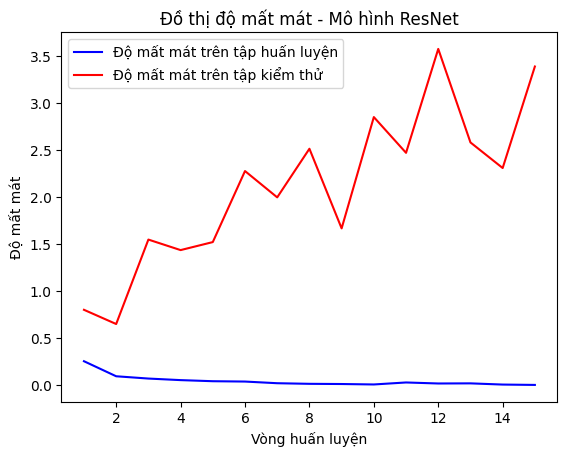

In [28]:
# Đồ thị hàm mất mát
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs = range(1, len(loss3)+1)
plt.plot(epochs, loss3, 'b', label = 'Độ mất mát trên tập huấn luyện')
plt.plot(epochs, val_loss3, 'r'
, label = 'Độ mất mát trên tập kiểm thử')
plt.title('Đồ thị độ mất mát - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ mất mát')
plt.legend()
plt.show()

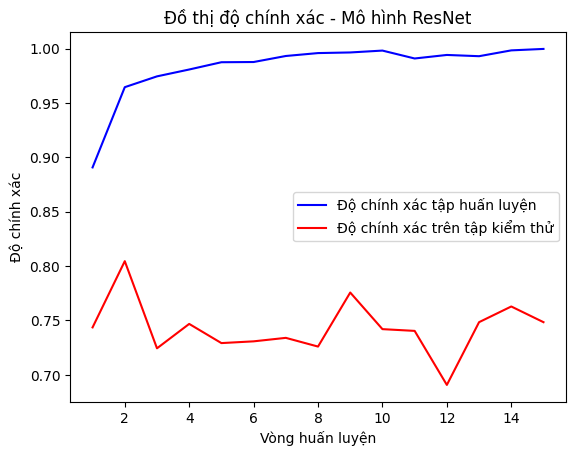

In [29]:
# Đồ thị độ chính xác của mô hình
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
plt.plot(epochs, acc3, 'b', label = 'Độ chính xác tập huấn luyện')
plt.plot(epochs, val_acc3, 'r', label = 'Độ chính xác trên tập kiểm thử')
plt.title('Đồ thị độ chính xác - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ chính xác')
plt.legend()
plt.show()

In [31]:
model.save('/content/drive/MyDrive/CNN_GRAY.h5')